In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import plot_functions as pf
import pandas as pd
import xarray as xr
import seaborn as sns #sets up styles and gives us more plotting options
sns.set()

#### Open an initial dataset (observed values) from 1_generated in generate_the_Wadden_Sed.ipynb file

In [2]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()

take only values from the uppermost layer:

In [3]:
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)
levelface.describe()

,par,hice,snowthick,icesurft,temperature,salinity,sigma,turbulence,ammonium,nitrate,sulfate,silicate,phosphate,oxygen,om_flux,chl_a
count,1095.000000,1095.0,1095.0,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1.095000e+03,1095.000000,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,56.332397,0.0,0.0,0.0,10.700646,30.484438,25.608339,0.000036,1.000000e-01,16.124231,25000.0,10.462073,0.616338,332.543217,0.001395,18.844109
std,23.048964,0.0,0.0,0.0,5.691322,0.708197,1.594859,0.000031,1.791053e-15,13.724963,0.0,8.133727,0.406156,47.042972,0.000877,9.769495
min,21.644333,0.0,0.0,0.0,2.145531,29.219625,22.645143,0.000009,1.000000e-01,0.198307,25000.0,0.754375,0.094500,255.017806,0.000155,0.000000
25%,33.247036,0.0,0.0,0.0,5.767865,29.952813,24.353865,0.000019,1.000000e-01,0.907292,25000.0,3.564215,0.241964,294.762602,0.000520,12.971875
50%,58.778526,0.0,0.0,0.0,10.443795,30.572593,25.663931,0.000025,1.000000e-01,16.035938,25000.0,5.939955,0.563480,324.720360,0.001395,19.532812
75%,79.421547,0.0,0.0,0.0,16.023899,30.967065,26.740268,0.000041,1.000000e-01,28.764583,25000.0,19.211458,0.918029,362.263498,0.002270,24.846443
max,86.162720,0.0,0.0,0.0,19.109524,32.490208,29.768699,0.000312,1.000000e-01,40.072916,25000.0,26.070694,1.504752,427.340630,0.002635,40.787321


In [4]:
par = levelface['par'].values[0:365].astype(np.float64)
temperature = levelface['temperature'].values[0:365].astype(np.float64)
no3 = levelface['nitrate'].values[0:365].astype(np.float64)
po4 = levelface['phosphate'].values[0:365].astype(np.float64)
si = levelface['silicate'].values[0:365].astype(np.float64)
o2 = levelface['oxygen'].values[0:365].astype(np.float64)
chl_a = levelface['chl_a'].values[0:365].astype(np.float64)
om_flux = levelface['om_flux'].values[0:365].astype(np.float64)
irradiance = par*86400/1000000 # convertion microM per second to M per day

In [5]:
ox = np.arange(1,366,1)

plot some data:

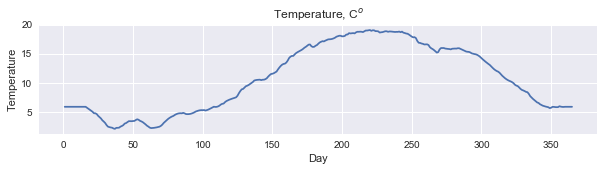

In [6]:
plt.plot(ox, temperature); plt.gcf().set_size_inches(10, 2);
plt.title('Temperature, C$^{o}$');
plt.xlabel('Day'); plt.ylabel('Temperature');

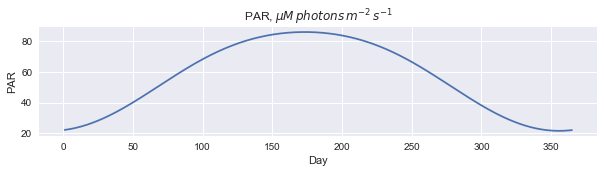

In [7]:
plt.plot(ox, par); plt.gcf().set_size_inches(10, 2);
plt.title('PAR, $\mu M\,photons\,m^{−2}\,s^{−1}$');
plt.xlabel('Day'); plt.ylabel('PAR');

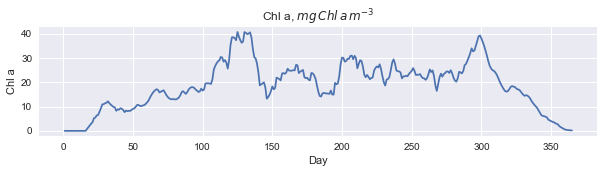

In [8]:
plt.plot(ox, chl_a); plt.gcf().set_size_inches(10, 2);
plt.title('Chl a, $mg\,Chl\,a\,m^{-3}$');
plt.xlabel('Day'); plt.ylabel('Chl a');

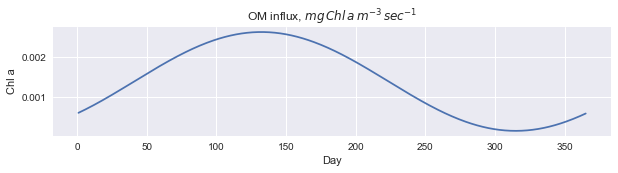

In [9]:
plt.plot(ox, om_flux); plt.gcf().set_size_inches(10, 2);
plt.title('OM influx, $mg\,Chl\,a\,m^{-3}\,sec^{-1}$');
plt.xlabel('Day'); plt.ylabel('Chl a');

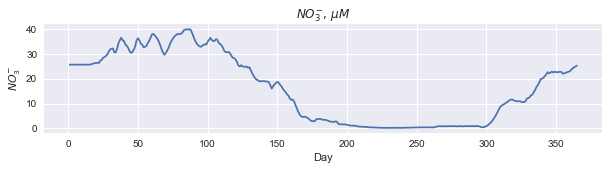

In [10]:
plt.plot(ox, no3); plt.gcf().set_size_inches(10, 2);
plt.title('$NO_{3}^{-},\,\mu M$');
plt.xlabel('Day'); plt.ylabel('$NO_{3}^{-}$');

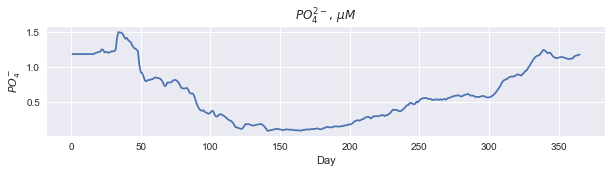

In [11]:
plt.plot(ox, po4); plt.gcf().set_size_inches(10, 2);
plt.title('$PO_{4}^{2-},\,\mu M$');
plt.xlabel('Day'); plt.ylabel('$PO_{4}^{-}$');

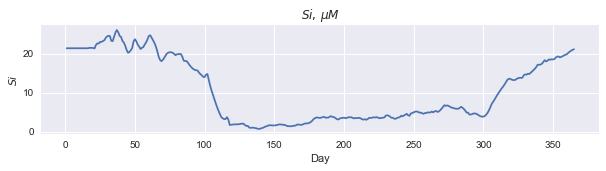

In [12]:
plt.plot(ox, si); plt.gcf().set_size_inches(10, 2);
plt.title('$Si,\,\mu M$');
plt.xlabel('Day'); plt.ylabel('$Si$');

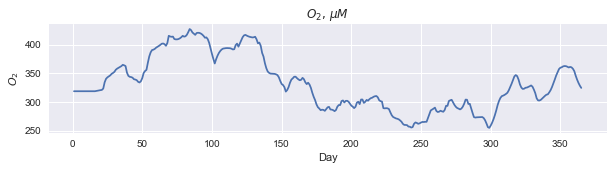

In [13]:
plt.plot(ox, o2); plt.gcf().set_size_inches(10, 2);
plt.title('$O_{2},\,\mu M$');
plt.xlabel('Day'); plt.ylabel('$O_{2}$');

#### Here we will test and visualize some functions we are going to use in the phytoplankton+biogeochemical model

Universal limiters and inhibitors:

In [14]:
def linearlimiter(k, r):
    return np.minimum(r/k, 1)

def monodlimiter(ks, r):
    return (r/(r+ks))

def monodinhibitor(ks, r):
    return (ks/(ks+r))

def hyper_limiter(threshold_value, r, coef):
    return 0.5+0.5*np.tanh((r-threshold_value)*coef)

def hyper_inhibitor(threshold_value, r, coef):
    return 0.5-0.5*np.tanh((r-threshold_value)*coef)

def exp_inhibitor(ks, r):
    return np.exp(-ks*r)

def exp_limiter(ks, r):
    return 1-np.exp(-ks*r)

def sigmoid_powered(ks, r, power):
    return np.power(r, power)/(np.power(ks, power)+np.power(r, power))

Compare some limiters with arbitrary input parameters

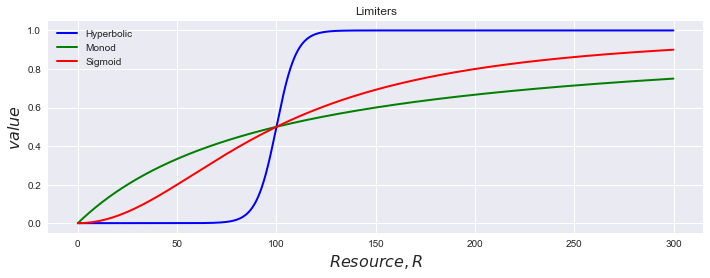

In [15]:
oxnut = np.arange(0, 300, 0.1)
# --- get an empty Figure and add an Axes
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1) # row-col-num
# --- line plot data on the Axes
ax.plot(oxnut, hyper_limiter(100, oxnut, 0.1), 'b-', linewidth=2, label=r'Hyperbolic')
ax.plot(oxnut, monodlimiter(100, oxnut), 'g-', linewidth=2, label=r'Monod')
ax.plot(oxnut, sigmoid_powered(100, oxnut, 2), 'r-', linewidth=2, label=r'Sigmoid')
# --- add title and axis labels
ax.set_title('Limiters')
ax.set_ylabel(r'$ value$', fontsize=16)
ax.set_xlabel(r'$Resource, R$', fontsize=16)
# --- plot a legend in the best location
ax.legend(loc='best')
# --- add grid – not in default classic style
ax.grid(True)
# --- improve the layout
fig.tight_layout(pad=1)

Light limiters:

In [16]:
def limlight(optimum, par):
    return (par/optimum)*np.exp(1-par/optimum)

Temperature limiters:

In [17]:
# ersem temperature limiter doi:10.5194/gmd-9-1293-2016
def limt(q10, temperature):
    return (np.power(q10,(temperature-10)/10)
           -np.power(q10,(temperature-32)/3 ) )

Chl:C relationship, Cloern et al., 1995: $\frac{Chl\,a}{C} = A_{0} + A e^{BT}e^{-CI}\tau$

In [18]:
def ChlCratio(temperature, irradiance, nutrient_limiter):
    """temperature - [C,
       irradiance - [mol quanta m-2 d-1]"""
    
    A0 = 0.003 # minimal Chl:C ratio
    A = 0.0154; B = 0.050; C = 0.059 # achieved by experiment
    
    return A0+A*np.exp(B*temperature)*np.exp(-1*C*irradiance)*nutrient_limiter

Light attenuation

In [19]:
def light_attenuation(k, z, I):
    """
    k is attenuation coefficient [m-1]
    z is depth, [m]
    I is the instantaneous irradiance at depth z (PAR), [microM quanta m-2 s-1]
    or daily irradiane [mol quanta m-2 d-1]
    """
    return I*np.exp(-1*k*z)

Calculate nutrient limiters

In [20]:
no3_limiter = sigmoid_powered(0.1, no3, 2)
si_limiter  = sigmoid_powered(0.1, si, 2)
po4_limiter = sigmoid_powered(0.1, po4, 2)

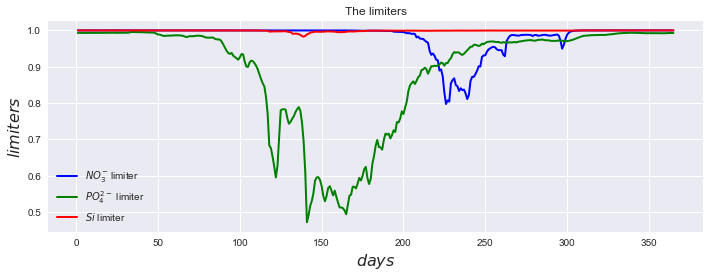

In [21]:
# --- get an empty Figure and add an Axes
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1) # row-col-num
# --- line plot data on the Axes
ax.plot(ox, no3_limiter, 'b-', linewidth=2, label=r'$NO_{3}^{-}$ limiter')
ax.plot(ox, po4_limiter, 'g-', linewidth=2, label=r'$PO_{4}^{2-}$ limiter')
ax.plot(ox, si_limiter, 'r-', linewidth=2, label=r'$Si$ limiter')
# --- add title and axis labels
ax.set_title('The limiters')
ax.set_ylabel(r'$limiters$', fontsize=16)
ax.set_xlabel(r'$days$', fontsize=16)
# --- plot a legend in the best location
ax.legend(loc='best')
# --- add grid – not in default classic style
ax.grid(True)
# --- improve the layout
fig.tight_layout(pad=1)

In [22]:
nutrient_limiter = [np.min([x, y, z]) for x, y, z in zip(no3_limiter, si_limiter, po4_limiter)];

In [23]:
ChlCratio_array = ChlCratio(temperature, light_attenuation(k=0.4, z=0.625, I=irradiance), nutrient_limiter)

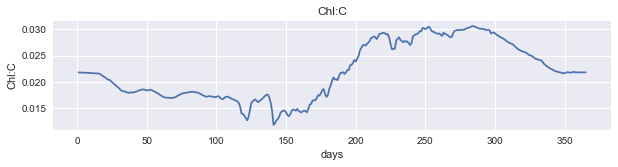

In [24]:
ox = np.arange(1,366,1)
plt.plot(ox,ChlCratio_array); plt.gcf().set_size_inches(10,2);
plt.title('Chl:C'); plt.xlabel('days'); plt.ylabel('Chl:C');

Photoperiod, hours

In [25]:
def photoperiod():
    import datetime
    from astral import Astral
    
    city_name = 'Vilnius'
    a = Astral()
    a.solar_depression = 'civil'
    city = a[city_name]
    
    date_list = pd.date_range(start='1/1/2018', end='31/12/2018')
    sun = [city.sun(date=x, local=True) for x in date_list] 
    diff = [sun[x]['sunset']-sun[x]['sunrise'] for x in range(0,len(sun))]
    
    return [diff[x].seconds/60/60 for x in range(0,len(diff))]

In [26]:
def photoperiod2(latitude):
    """
    From the Fennel "Marine Modelling" - page 130 and ersem zenith_angle module
    """
    
    latitude = np.pi/180*latitude
    
    a0 = 0.006918
    a1 =-0.399912
    a2 =-0.006758
    a3 =-0.002697
    b1 = 0.070257
    b2 = 0.000907
    b3 = 0.001480
    
    days = np.arange(1,366,1)
    th0 = np.pi*days/182.5
    th02 = 2*th0
    th03 = 3*th0
    
    delta =(a0
          + a1*np.cos(th0)+b1*np.sin(th0)
          + a2*np.cos(th02)+b2*np.sin(th02)
          + a3*np.cos(th03)+b3*np.sin(th03))
    
    wh = (2*np.pi)/24
    deltaday = (2/wh)*np.arccos(-np.tan(latitude)*np.tan(delta))
    
    return deltaday

Biomass specific photosynthetic rate, $mg\,C\,(mg\,Chl\,a\,d)^{-1}$: $P^{B} = D p^{B}_{m}(1 - \exp{\frac{I_{t} \alpha}{p^{B}_{m}}})$

In [27]:
def biorate(D, pbm, alpha, I):
    """
    D is photoperiod, hours
    pbm is the maximum hourly rate of photosynthesis, [mg C (mg Chl a h)-1], by experiment
    alpha is photosynthetic efficiency at low irradiance, by experiment
    I is instanteneous irradance, PAR [microM quanta m-2 s-1]
    """
    return (D*pbm*(1-np.exp(-1*I*alpha/pbm)))

In [28]:
photoperiod_array = np.array(photoperiod2(54.88))
biorate_array = biorate(D=photoperiod_array, pbm=8, alpha=0.05, I=light_attenuation(0.5,0.625, par))

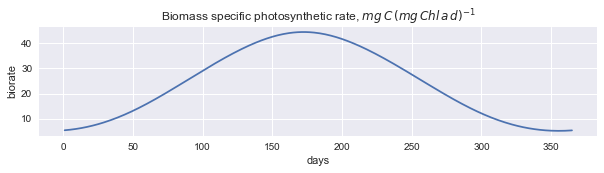

In [29]:
plt.plot(ox, biorate_array); plt.gcf().set_size_inches(10,2);
plt.title('Biomass specific photosynthetic rate, $mg\,C\,(mg\,Chl\,a\,d)^{-1}$');
plt.xlabel('days'); plt.ylabel('biorate');

Daily specific growth rate with respiration included: $\mu = R_{1} P^{B}\frac{Chl\,a}{C} - R_{0}$

In [30]:
def daily_growth(biorate, ChlCratio):
    """
    Coefficiens inside evaluate respiration;
    biorate is the daily rate of photosynthesis, [mg C (mg Chl a d)-1]
    ChlCratio, joint nutrients limiter
    """
    answer = 0.85*biorate*ChlCratio-0.015
    
    return np.max([answer, 0])
    #return [np.max([0, x]) for x in answer]

In [31]:
def excretion(kexc, phy):
    return kexc*phy

def mortality(kmrt, phy, o2):
    return phy*(kmrt+hyper_inhibitor(60, o2, 1)*0.45+hyper_inhibitor(20, o2, 1)*0.45)

Gross primary production

In [32]:
def daily_growth_rate(kno3, ksi, kpo4, 
                      k, depth,
                      pbm, alpha,
                      no3_d, si_d, po4_d,
                      temperature_d, irradiance_d, photoperiod_d, par_d):
    """It returns net primary production, so respiration is included
       kno3, ksi, kpo4, k, pbm, alpha - parameters
       other ones - variables for the current day"""
    
    no3_limiter = sigmoid_powered(kno3, no3_d, 2)
    si_limiter  = sigmoid_powered(ksi, si_d, 2)
    po4_limiter = sigmoid_powered(kpo4, po4_d, 2)
    nutrient_limiter = np.min([no3_limiter, si_limiter, po4_limiter])
    
    ChlCratio_d = ChlCratio(temperature_d, light_attenuation(k=k, z=depth, I=irradiance_d), nutrient_limiter)
    biorate_d = biorate(D=photoperiod_d, pbm=pbm, alpha=alpha, I=light_attenuation(k=k, z=depth, I=par_d))
    daily_growth_d = daily_growth(biorate_d, ChlCratio_d)
    
    return daily_growth_d

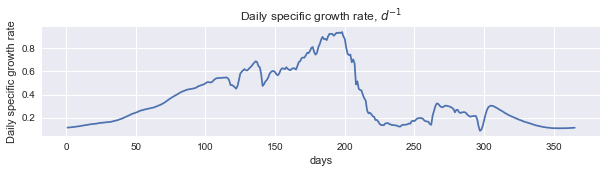

In [33]:
daily_growth_array = [daily_growth_rate(
                              kno3=1, ksi=0.5, kpo4=0.1,
                              k=0.04, depth=0.625,
                              pbm=8, alpha=0.05,
                              no3_d=x1, si_d=x2, po4_d=x3,
                              temperature_d=x4, irradiance_d=x5, photoperiod_d=x6, par_d=x7) 
                      for x1, x2, x3, x4, x5, x6, x7 in 
                      zip(no3, si, po4, temperature, irradiance, photoperiod_array, par)]

plt.plot(ox,daily_growth_array); plt.gcf().set_size_inches(10,2);
plt.title('Daily specific growth rate, $d^{-1}$');
plt.xlabel('days'); plt.ylabel('Daily specific growth rate');

Phytoplankton itself

In [34]:
def c_from_ratio(chl_a, temperature, 
                 k, I, depth,
                 kno3, ksi, kpo4,
                 no3, si, po4):
    """k, depth, kno3, ksi, kpo4 - parameters"""
    
    no3_limiter = monodlimiter(kno3, no3)
    si_limiter = monodlimiter(ksi, si)
    po4_limiter = monodlimiter(kpo4, po4)
    
    nutrient_limiter = [np.min([x, y, z]) for x, y, z in zip(no3_limiter, si_limiter, po4_limiter)];
    
    return (  chl_a
            / ChlCratio(temperature, light_attenuation(k=k, z=depth, I=I), nutrient_limiter))

In [35]:
PhyC_array = c_from_ratio(chl_a=chl_a, temperature=temperature,
                          k=0.04, I=irradiance, depth=0.625,
                          kno3=1, ksi=0.5, kpo4=0.1,
                          no3=no3, si=si, po4=po4)

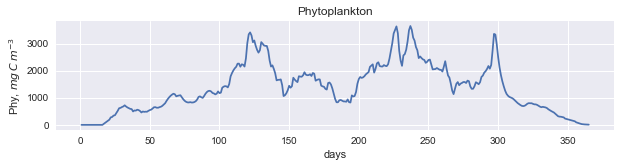

In [36]:
plt.plot(ox,PhyC_array); plt.gcf().set_size_inches(10,2);
plt.title('Phytoplankton'); plt.xlabel('days'); plt.ylabel('Phy, $mg\,C\,m^{-3}$');

####  Porosities

In [37]:
def porosity(z, z_swi, phi_swi, phi_inf):
    k_phi = 0.04
    k = -(z-z_swi)/k_phi
    return (phi_inf+(phi_swi-phi_inf)*np.exp(k))

In [38]:
porosity(2.505, 2.5, 0.75, 0.25)

0.69124845129229895

In [39]:
z = np.linspace(2.505, 2.595, 10)

In [40]:
phi_inf_array = np.arange(0.05, 0.36, 0.01)

In [41]:
phi_swi_array = np.arange(0.45, 0.86, 0.01)

In [42]:
for phi_swi in phi_swi_array:
    for phi_inf in phi_inf_array:
        if (0.432 < sum(porosity(z, 2.5, phi_swi, phi_inf))/10 < 0.434):
            print(phi_swi, phi_inf)

0.61 0.33
0.63 0.32
0.68 0.29
0.7 0.28
0.73 0.26
0.75 0.25
0.8 0.22
0.82 0.21


#### Carbonates dissolution estimation

In [43]:
ds = xr.open_dataset('data/low_sulfate_reduction_rate/5_po75-25_di10e-9/water.nc')
alkflux_df = ds['B_C_Alk   _flux'].to_dataframe()
biogrow_df = ds['B_BIO_GrowthPhy'].to_dataframe()
omresp_df  = ds['B_BIO_DcPOC_O2'].to_dataframe()
alk_df     = ds['B_C_Alk'].to_dataframe()
alkflux_bottom = alkflux_df.groupby('z_faces').get_group(2.5)
omresp_bottom  = omresp_df.groupby('z').get_group(2.4749999046325684)
biogrow_surfac = biogrow_df.groupby('z').get_group(0.625)
alk_surface    = alk_df.groupby('z').get_group(0.625)
alk_surface_year = alk_surface.loc['2011-01-01':'2011-12-31']

In [44]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [45]:
year_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [46]:
year_acc_days = np.cumsum(year_days)
year_acc_days

array([ 31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334, 365], dtype=int32)

In [47]:
alk_year_delta = []
alk_year = []
bio_year = []
res_year = []
for month in year:
    alk_delta_month = alk_surface.loc[month[0]:month[1]]
    alk_month = alkflux_bottom.loc[month[0]:month[1]]
    bio_month = biogrow_surfac.loc[month[0]:month[1]]
    res_month =  omresp_bottom.loc[month[0]:month[1]]
    alk_year_delta.append(alk_delta_month['B_C_Alk'][0])
    alk_year.append(alk_month['B_C_Alk   _flux'].mean())
    bio_year.append(bio_month['B_BIO_GrowthPhy'].mean())
    res_year.append(res_month['B_BIO_DcPOC_O2'].mean())

In [48]:
bio_year_quotas = np.array(bio_year)/sum(bio_year)
alk_year_quotas = np.array(alk_year)/sum(alk_year)
res_year_quotas = np.array(res_year)/sum(res_year)

In [49]:
caco3_precipitation = bio_year_quotas*1000/year_days #mM
caco3_precipitation

array([ 0.06591641,  0.07615452,  0.3328146 ,  4.60330779,  4.75019771,
        4.50845977,  4.89712587,  4.39132298,  4.06138277,  3.49720824,
        1.39452357,  0.15694502])

In [50]:
caco3_dissolution = res_year_quotas*1000/year_days
caco3_dissolution

array([ 0.71606399,  1.67373148,  1.92953585,  2.77043634,  4.34911983,
        5.93712477,  5.24333561,  3.73863469,  2.96444336,  1.73688719,
        1.25562211,  0.52212352])

In [51]:
ca_flux = caco3_dissolution - caco3_precipitation

In [52]:
ca_flux

array([ 0.65014758,  1.59757696,  1.59672124, -1.83287145, -0.40107788,
        1.42866501,  0.34620973, -0.65268829, -1.09693941, -1.76032105,
       -0.13890146,  0.3651785 ])

In [53]:
ca_array = np.array(ca_flux)/2.5*2

In [54]:
ca_array

array([ 0.52011806,  1.27806157,  1.277377  , -1.46629716, -0.3208623 ,
        1.142932  ,  0.27696779, -0.52215064, -0.87755153, -1.40825684,
       -0.11112117,  0.2921428 ])

In [55]:
alk_surface_year = alk_surface_year.reset_index()
alk_array = np.array(alk_surface_year['B_C_Alk'])
alkflux_bottom_year = alkflux_bottom.loc['2011-01-01':'2011-12-31']
alkflux_bottom_year = alkflux_bottom_year.reset_index()

#### Calculate a total increment of Ca$^{2+}$ concentration changes due to fluxes previously estimated

In [56]:
calpart = np.zeros(365)
day = 0
last_entry = 0
for month, increment in zip(year_days, ca_array):
    temp = np.linspace(last_entry+increment, last_entry+increment*month, num=month)
    calpart[day:day+month] = temp
    last_entry = temp[-1]
    day += month

In [57]:
caco3_dis = np.zeros(365)
day = 0
for month, increment in zip(year_days, caco3_dissolution):
    caco3_dis[day:day+month] = increment
    day += month

In [58]:
caco3_pre = np.zeros(365)
day = 0
for month, increment in zip(year_days, caco3_precipitation):
    caco3_pre[day:day+month] = increment
    day += month

In [59]:
result_array = alk_array + calpart

C:\Users\Yakubov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


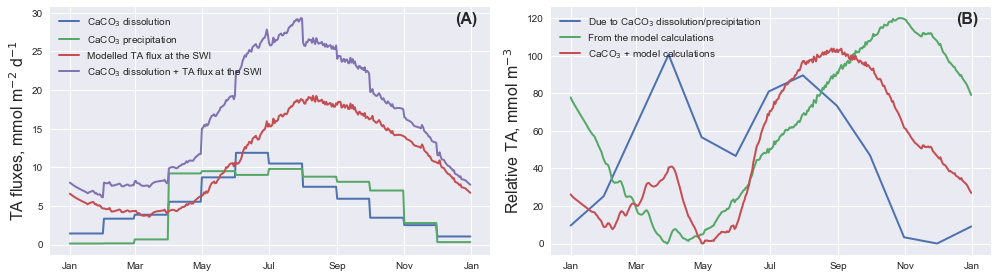

In [60]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 2, 1) # row-col-num
#ax1.xaxis_date()
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.plot(alk_surface_year['time'], caco3_dis*2, linewidth=2, label=r'CaCO$_3$ dissolution')
ax1.plot(alk_surface_year['time'], caco3_pre*2, linewidth=2, label=r'CaCO$_3$ precipitation')
ax1.plot(alk_surface_year['time'], alkflux_bottom_year['B_C_Alk   _flux'], linewidth=2, label=r'Modelled TA flux at the SWI')
ax1.plot(alk_surface_year['time'], caco3_dis*2+alkflux_bottom_year['B_C_Alk   _flux'], linewidth=2, 
         label=r'CaCO$_3$ dissolution + TA flux at the SWI')
# --- add title and axis labels
#ax.set_title('Alkalinity fluxes')
ax1.set_ylabel('TA fluxes, mmol m$^{-2}$ d$^{-1}$', fontsize=16)
#ax.set_xlabel('Month', fontsize=16)
# --- plot a legend in the best location
ax1.legend(loc='upper left')#, title='Alkalinity fluxes')
# --- add grid – not in default classic style
ax1.grid(True)
ax = fig.add_subplot(1, 2, 2) # row-col-num
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.plot(alk_surface_year['time'], calpart-calpart.min(), linewidth=2, label=r'Due to CaCO$_3$ dissolution/precipitation')
ax.plot(alk_surface_year['time'], alk_array-alk_array.min(), linewidth=2, label=r'From the model calculations')
ax.plot(alk_surface_year['time'], result_array - result_array.min(), linewidth=2, label=r'CaCO$_3$ + model calculations')
# --- add title and axis labels
#ax.set_title('Alkalinity fluxes')
ax.set_ylabel('Relative TA, mmol m$^{-3}$', fontsize=16)
#ax.set_xlabel('Month', fontsize=16)
# --- plot a legend in the best location
ax.legend(loc='upper left')#, title='Alkalinity increments')
# --- add grid – not in default classic style
#ax.grid(True)

fntsz = 16
x_text = 0.97
y_text = 0.98
labels = ('(A)', '(B)')
# --- improve the layout   
for i,axis in enumerate((ax1,ax)):
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axis.text(x_text, y_text, labels[i], transform=axis.transAxes,
              fontsize=fntsz, fontweight='bold', va='top', ha='right')
        
fig.tight_layout(pad=1)
plt.show()

In [61]:
ca_array

array([ 0.52011806,  1.27806157,  1.277377  , -1.46629716, -0.3208623 ,
        1.142932  ,  0.27696779, -0.52215064, -0.87755153, -1.40825684,
       -0.11112117,  0.2921428 ])

In [62]:
ca_array_monthly = ca_array*year_days
ca_array_monthly

array([ 16.12365996,  35.78572383,  39.59868686, -43.98891487,
        -9.94673145,  34.28796014,   8.58600134, -16.18666971,
       -26.32654583, -43.65596205,  -3.33363504,   9.05642681])

In [63]:
alk_array = np.array(alk_year_delta)

In [64]:
alk_array = alk_array - alk_array.min()
alk_array

array([  75.07739258,   40.81958008,   16.93505859,    0.        ,
          2.23095703,   20.9230957 ,   47.81054688,   66.71899414,
         87.87426758,  105.78027344,  116.46850586,  104.09570312], dtype=float32)

#### Alkalinity fluxes quotas

In [110]:
ds = xr.open_dataset('data/low_sulfate_reduction_rate/5_po75-25_di10e-9/water.nc')
alkflux_df = ds['B_C_Alk   _flux'].to_dataframe()
nh4flux_df = ds['B_NUT_NH4 _flux'].to_dataframe()
no2flux_df = ds['B_NUT_NO2 _flux'].to_dataframe()
no3flux_df = ds['B_NUT_NO3 _flux'].to_dataframe()
po4flux_df = ds['B_NUT_PO4 _flux'].to_dataframe()
so4flux_df = ds['B_S_SO4   _flux'].to_dataframe()
alkflux_bottom = alkflux_df.groupby('z_faces').get_group(2.5)
nh4flux_bottom = nh4flux_df.groupby('z_faces').get_group(2.5)
no2flux_bottom = no2flux_df.groupby('z_faces').get_group(2.5)
no3flux_bottom = no3flux_df.groupby('z_faces').get_group(2.5)
po4flux_bottom = po4flux_df.groupby('z_faces').get_group(2.5)
so4flux_bottom = so4flux_df.groupby('z_faces').get_group(2.5)

In [111]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [112]:
year_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [113]:
alk_year = []
nh4_year = []
no2_year = []
no3_year = []
po4_year = []
so4_year = []
for month in year:
    alk_month = alkflux_bottom.loc[month[0]:month[1]]
    nh4_month = nh4flux_bottom.loc[month[0]:month[1]]
    no2_month = no2flux_bottom.loc[month[0]:month[1]]
    no3_month = no3flux_bottom.loc[month[0]:month[1]]
    po4_month = po4flux_bottom.loc[month[0]:month[1]]
    so4_month = so4flux_bottom.loc[month[0]:month[1]]
    alk_year.append(alk_month['B_C_Alk   _flux'].mean())
    nh4_year.append(nh4_month['B_NUT_NH4 _flux'].mean())
    no2_year.append(no2_month['B_NUT_NO2 _flux'].mean())
    no3_year.append(no3_month['B_NUT_NO3 _flux'].mean())
    po4_year.append(po4_month['B_NUT_PO4 _flux'].mean())
    so4_year.append(so4_month['B_S_SO4   _flux'].mean())

In [115]:
alk = np.array(alk_year)
nh4 = np.array(nh4_year)
no2 = np.array(no2_year)
no3 = np.array(no3_year)
po4 = np.array(po4_year)
so4 = np.array(so4_year)

In [116]:
all_components = nh4-no2-no3-po4-2*so4

In [71]:
nh4_quota = nh4/all_components
nh4_quota

array([ 0.12761769,  0.14015886,  0.14685221,  0.14037821,  0.14172562,
        0.11023074,  0.09720021,  0.08789225,  0.09185691,  0.09640039,
        0.1047076 ,  0.11332254])

In [72]:
no2_quota = -no2/all_components
no2_quota

array([-0.00042005, -0.00080647, -0.001686  , -0.00230512,  0.00031057,
        0.00120826,  0.00013709,  0.00013442,  0.00033019,  0.00042988,
        0.00280258,  0.00182244])

In [73]:
no3_quota = -no3/all_components
no3_quota

array([ 0.07953435,  0.11249185,  0.13687219,  0.09518522,  0.0326903 ,
        0.00513885,  0.00082546,  0.00022191,  0.00035428,  0.00071845,
        0.00523538,  0.03760013])

In [74]:
po4_quota = -po4/all_components
po4_quota

array([-0.00453248, -0.00367439, -0.0027573 , -0.00452861, -0.00782811,
       -0.00693703, -0.00620746, -0.00565129, -0.0059348 , -0.00625626,
       -0.00679275, -0.00589359])

In [75]:
so4_quota = -so4*2/all_components
so4_quota

array([ 0.79780048,  0.75183015,  0.7207189 ,  0.7712703 ,  0.83310162,
        0.89035918,  0.90804471,  0.91740271,  0.91339342,  0.90870753,
        0.89404719,  0.85314848])

In [76]:
nh4_quota+no2_quota+no3_quota+po4_quota+so4_quota

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

#### Alkalinity to reduced sulfur compounds fluxes quotas

In [119]:
ds1 = xr.open_dataset('data/low_sulfate_reduction_rate/2_po75-25_di1e-9/water.nc')
ds2 = xr.open_dataset('data/low_sulfate_reduction_rate/5_po75-25_di10e-9/water.nc')
ds3 = xr.open_dataset('data/low_sulfate_reduction_rate/10_po75-25_di35e-9/water.nc')

In [120]:
ds = ds3

alkflux_df = ds['B_C_Alk   _flux'].to_dataframe()
nh4flux_df = ds['B_NUT_NH4 _flux'].to_dataframe()
no2flux_df = ds['B_NUT_NO2 _flux'].to_dataframe()
no3flux_df = ds['B_NUT_NO3 _flux'].to_dataframe()
po4flux_df = ds['B_NUT_PO4 _flux'].to_dataframe()
so4flux_df = ds['B_S_SO4   _flux'].to_dataframe()
h2s__flux_df = ds['B_S_H2S   _flux'].to_dataframe()
s0___flux_df = ds['B_S_S0    _flux'].to_dataframe()
s2o3_flux_df = ds['B_S_S2O3  _flux'].to_dataframe()

alkflux_bottom = alkflux_df.groupby('z_faces').get_group(2.5)
nh4flux_bottom = nh4flux_df.groupby('z_faces').get_group(2.5)
no2flux_bottom = no2flux_df.groupby('z_faces').get_group(2.5)
no3flux_bottom = no3flux_df.groupby('z_faces').get_group(2.5)
po4flux_bottom = po4flux_df.groupby('z_faces').get_group(2.5)
so4flux_bottom = so4flux_df.groupby('z_faces').get_group(2.5)
h2sflux_bottom  = h2s__flux_df.groupby('z_faces').get_group(2.5)
s0flux_bottom   = s0___flux_df.groupby('z_faces').get_group(2.5)
s2o3flux_bottom = s2o3_flux_df.groupby('z_faces').get_group(2.5)

In [121]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [122]:
alk_year = []
nh4_year = []
no2_year = []
no3_year = []
po4_year = []
so4_year = []
h2s_year = []
s0_year = []
s2o3_year = []
for month in year:
    alk_month = alkflux_bottom.loc[month[0]:month[1]]
    nh4_month = nh4flux_bottom.loc[month[0]:month[1]]
    no2_month = no2flux_bottom.loc[month[0]:month[1]]
    no3_month = no3flux_bottom.loc[month[0]:month[1]]
    po4_month = po4flux_bottom.loc[month[0]:month[1]]
    so4_month = so4flux_bottom.loc[month[0]:month[1]]
    h2s_month = h2sflux_bottom.loc[month[0]:month[1]]
    s0_month = s0flux_bottom.loc[month[0]:month[1]]
    s2o3_month = s2o3flux_bottom.loc[month[0]:month[1]]
    alk_year.append(alk_month['B_C_Alk   _flux'].mean())
    nh4_year.append(nh4_month['B_NUT_NH4 _flux'].mean())
    no2_year.append(no2_month['B_NUT_NO2 _flux'].mean())
    no3_year.append(no3_month['B_NUT_NO3 _flux'].mean())
    po4_year.append(po4_month['B_NUT_PO4 _flux'].mean())
    so4_year.append(so4_month['B_S_SO4   _flux'].mean())
    h2s_year.append(h2s_month['B_S_H2S   _flux'].mean())
    s0_year.append(s0_month['B_S_S0    _flux'].mean())
    s2o3_year.append(s2o3_month['B_S_S2O3  _flux'].mean())

In [123]:
alk = np.array(alk_year)
nh4 = np.array(nh4_year)
no2 = np.array(no2_year)
no3 = np.array(no3_year)
po4 = np.array(po4_year)
so4 = np.array(so4_year)
h2s = np.array(h2s_year)
s0 = np.array(s0_year)
s2o3 = np.array(s2o3_year)

In [124]:
s_total = h2s + s0 + 2*s2o3

In [125]:
all_components = nh4-no2-no3-po4-2*so4

In [138]:
alk_so4_quota = alk*so4_quota

In [139]:
alk_so4_quota

array([  2.6335665 ,   1.94442364,   2.34720635,   4.24326319,
        10.71382562,  20.37966562,  27.62150249,  28.91894869,
        24.54836815,  18.94343954,  13.42754474,   6.33397186])

In [142]:
so4direct_quota = -2*so4

In [144]:
so4direct_quota

array([  1.83781064,   1.4958303 ,   1.94537723,   3.69711995,
         9.89030838,  19.89976311,  27.17504501,  28.34657288,
        23.86533546,  18.24912262,  12.80105114,   5.27182293])

In [145]:
sulfurquota = s_total*2

In [146]:
sulfurquota

array([  3.13922779,   1.45089053,   1.33601918,   2.56296048,
         7.22983027,  15.72272515,  23.24894357,  25.92327738,
        23.18665671,  18.79629397,  14.27755094,   8.38100287])

In [147]:
sum(alk_so4_quota)-sum(sulfurquota)

16.800347544414166

In [148]:
sum(so4direct_quota)-sum(sulfurquota)

9.2197808111086488

#### Advection TA change

In [88]:
ds = xr.open_dataset('data/advective_ta/1_10e-9/water.nc')

In [89]:
nh4ta_df = ds['TA_due_to_NH4'].to_dataframe()
no3ta_df = ds['TA_due_to_NO3'].to_dataframe()
po4ta_df = ds['TA_due_to_PO4'].to_dataframe()
so4ta_df = ds['TA_due_to_SO4'].to_dataframe()

In [90]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [91]:
nh4ta_year = []
no3ta_year = []
po4ta_year = []
so4ta_year = []
for month in year:
    nh4ta_month = nh4ta_df.loc[month[0]:month[1]]
    no3ta_month = no3ta_df.loc[month[0]:month[1]]
    po4ta_month = po4ta_df.loc[month[0]:month[1]]
    so4ta_month = so4ta_df.loc[month[0]:month[1]]
    nh4ta_year.append(nh4ta_month['TA_due_to_NH4'].sum())
    no3ta_year.append(no3ta_month['TA_due_to_NO3'].sum())
    po4ta_year.append(po4ta_month['TA_due_to_PO4'].sum())
    so4ta_year.append(so4ta_month['TA_due_to_SO4'].sum())

In [92]:
nh4ta = np.array(nh4ta_year)
no3ta = np.array(no3ta_year)
po4ta = np.array(po4ta_year)
so4ta = np.array(so4ta_year)
total = nh4ta+no3ta+po4ta+so4ta

In [93]:
nh4ta

array([ -58.43408203,  -34.83994675,  -28.89142227,  -20.69546509,
        -59.6980896 ,  -47.58239746,  -11.02152443,  -11.31798077,
        -18.16998863,  -40.8519249 , -136.06344604, -113.19208527], dtype=float32)

In [94]:
no3ta

array([ -38.26072311,  -31.13687325,  -46.6659584 , -210.63392639,
        -96.94878387,  -44.91412735,  -40.2640419 ,   -2.06784773,
         -4.05427408,   -5.99329805,  -52.66889954,  -53.29138565], dtype=float32)

In [95]:
po4ta

array([  2.15744686,   1.73678148,   0.18063708, -12.06846523,
        -3.07790613,  -1.52483726,  -2.44245434,   0.25361025,
         0.86485177,   2.45373607,   6.17888165,   5.40709448], dtype=float32)

In [96]:
so4ta

array([ 59.16749191,  45.48974609,  39.55337524,  18.93574333,
       -17.42342567, -27.91056824, -39.04601669, -51.58440399,
       -41.02310181, -30.45923233,  -3.62286568,  35.62823486], dtype=float32)

In [97]:
total

array([ -35.36986923,  -18.75029755,  -35.82337189, -224.46211243,
       -177.14822388, -121.93192291,  -92.77404022,  -64.7166214 ,
        -62.38251495,  -74.85072327, -186.17633057, -125.44815063], dtype=float32)

In [98]:
sum(so4ta)

-12.295022964477539

In [99]:
sum(total)

-1219.8341789245605